<a href="https://colab.research.google.com/github/DJCordhose/deep-learning-crash-course-notebooks/blob/master/tf-v2/ux-rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training on Mouse-Movements on the Server

In [0]:
# for colab
# !pip install -q tf-nightly-gpu-2.0-preview

In [1]:
import tensorflow as tf
print(tf.__version__)

1.13.1


In [2]:
# a small sanity check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print("This works: {}".format(hello))

This works: Tensor("Const:0", shape=(), dtype=string)


In [3]:
# this should return True even on Colab
tf.test.is_gpu_available()

True

In [4]:
tf.test.is_built_with_cuda()

True

In [5]:
tf.executing_eagerly()

False

## load data

In [6]:
import pandas as pd
print(pd.__version__)

0.22.0


In [0]:
# local
# URL = '../data/sample4.json'

# remote
URL = 'https://raw.githubusercontent.com/DJCordhose/ux-by-tfjs/master//data/sample4.json'


df = pd.read_json(URL, typ='series')

In [8]:
len(df)

236

In [9]:
df.head()

0    {'x': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0...
1    {'x': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0...
2    {'x': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0...
3    {'x': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0...
4    {'x': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0...
dtype: object

In [0]:
X = [item['x'] for item in df]

In [11]:
X[0]

[[0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0,

In [0]:
y = [item['y'] - 1 for item in df]

In [13]:
y[0]

0

## pre-process data into chunks

In [0]:
from math import floor

def make_chunks(list_to_chunk, chunk_size):
    length = len(list_to_chunk)
    assert length / chunk_size == floor(length / chunk_size), "length of data must be multiple of segment length"
    for chunk_start in range(0, length, chunk_size):
        yield list_to_chunk[chunk_start : chunk_start + chunk_size]

In [0]:
import numpy as np

CHUNK_SIZE = 25
# only use the final segments 
SEGMENTS = 2

X_expanded = []
y_expanded = []

for x_el, y_el in zip(X, y):
    chunks = list(make_chunks(x_el, CHUNK_SIZE))
    chunks = chunks[len(chunks) - SEGMENTS:]
    labels = [y_el] * SEGMENTS
    for seq, label in zip(chunks, labels):
        X_expanded.append(seq)
        y_expanded.append(label)

X_expanded = np.array(X_expanded)
y_expanded = np.array(y_expanded)

In [16]:
X_expanded.shape

(472, 25, 5)

In [17]:
X_expanded[100]

array([[686, 438,   2,  -2,   7],
       [686, 437,   0,  -2,  15],
       [683, 439,  -6,   4,  28],
       [676, 447, -14,  16,   7],
       [668, 457, -16,  20,   9],
       [658, 468, -20,  22,   7],
       [653, 475, -10,  14,   0],
       [648, 480, -10,  10,   9],
       [645, 484,  -6,   8,   1],
       [644, 486,  -2,   4,   8],
       [643, 486,  -2,   0,   7],
       [643, 487,   0,   2,  14],
       [646, 485,   6,  -4,  22],
       [658, 478,  24, -14,   6],
       [676, 463,  36, -30,   8],
       [693, 448,  34, -30,   9],
       [717, 427,  48, -42,   5],
       [733, 415,  32, -24,   8],
       [743, 406,  20, -18,   6],
       [747, 402,   8,  -8,   6],
       [748, 401,   2,  -2,   8],
       [749, 401,   2,   0,   7],
       [750, 401,   2,   0,   9],
       [750, 404,   0,   6,  20],
       [747, 411,  -6,  14,   6]])

In [18]:
X_expanded[100][0]

array([686, 438,   2,  -2,   7])

In [19]:
y_expanded[100]

1

In [20]:
np.unique(y_expanded)

array([0, 1, 2])

In [0]:
assert np.array_equal(np.unique(y_expanded), [0, 1, 2])

## Training

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Bidirectional, BatchNormalization
from tensorflow.keras.models import Sequential, Model

In [23]:
n_steps = len(X_expanded[0])
n_features = len(X_expanded[0][0])
n_buttons = 3

model = Sequential()
model.add(SimpleRNN(units=50, activation='tanh', input_shape=(n_steps, n_features), name="RNN_Input", 
# model.add(GRU(units=50, activation='tanh', input_shape=(n_steps, n_features), name="RNN_Input", 
# recurrent_dropout makes things slow              
#               dropout=0.1, recurrent_dropout=0.1))
                dropout=0.1))
# model.add(GRU(units=50, activation='tanh', input_shape=(n_steps, n_features), name="RNN_Input"))
model.add(BatchNormalization())
model.add(Dense(units=n_buttons, name='softmax', activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [24]:
%%time

EPOCHS = 200
BATCH_SIZE = 200

history = model.fit(X_expanded, y_expanded, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, verbose=0, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
CPU times: user 17.8 s, sys: 2.28 s, total: 20.1 s
Wall time: 14.2 s


In [25]:
loss, accuracy = model.evaluate([X_expanded], y_expanded, batch_size=BATCH_SIZE)
accuracy

472/472 [==============================] - 0s 107us/sample - loss: 0.6857 - acc: 0.7542


0.7542373

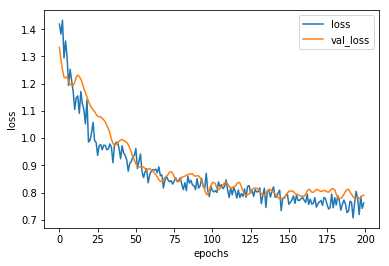

In [26]:
%matplotlib inline

import matplotlib.pyplot as plt

# plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(['loss', 'val_loss'])

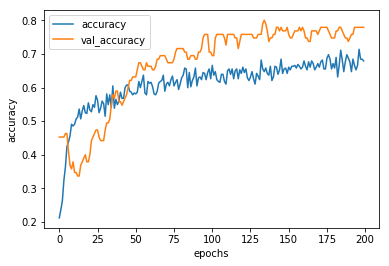

In [27]:
plt.ylabel('accuracy')
plt.xlabel('epochs')

# TF 2.0
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.legend(['accuracy', 'val_accuracy'])

In [28]:
model.predict([[X_expanded[0]]])

array([[0.60764664, 0.1283687 , 0.26398465]], dtype=float32)

In [29]:
model.predict([[X_expanded[0]]]).argmax()

0

In [30]:
y_expanded[0]

0

In [0]:
y_pred = model.predict([X_expanded]).argmax(axis=1)

In [34]:
# TF 2.0
cm = tf.math.confusion_matrix(labels=y_expanded, predictions=y_pred)
cm

AttributeError: ignored

In [0]:
# import seaborn as sns

# classes = ["Left Button", "Middle Button", "Right Button"]

# sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)

## Convert Model into tfjs format

In [0]:
model.save('ux.hd5')

In [37]:
!ls -l

total 72
drwxr-xr-x 1 root root  4096 Apr  4 20:20 sample_data
-rw-r--r-- 1 root root 67760 Apr 12 08:33 ux.hd5


In [38]:
!pip install -q tensorflowjs

    100% |████████████████████████████████| 81kB 12.6MB/s 
    100% |████████████████████████████████| 13.9MB 1.8MB/s 
    100% |████████████████████████████████| 86.2MB 251kB/s 
    100% |████████████████████████████████| 3.0MB 7.1MB/s 
    100% |████████████████████████████████| 61kB 21.0MB/s 
    100% |████████████████████████████████| 358kB 19.2MB/s 
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.


In [0]:
!tensorflowjs_converter --input_format keras ux.hd5 tfjs

In [40]:
!ls -l tfjs

total 20
-rw-r--r-- 1 root root 12612 Apr 12 08:35 group1-shard1of1.bin
-rw-r--r-- 1 root root  3313 Apr 12 08:35 model.json


Download using _Files_ menu on the left